In [1]:
import pandas as pd
import numpy as np

In [2]:
# import pandas as pd
# import numpy as np
# np.random.seed(37) 

import types
from botocore.client import Config
import ibm_boto3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score,\
                            f1_score, roc_auc_score, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras import backend as K


import tensorflow as tf
import itertools

from time import time

In [3]:
feat_keys = ['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']
all_keys = feat_keys[:] + ['attack']

In [4]:
df = pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_Best.csv', delimiter=';', index_col=False)

# Clean column names
df.columns = df.columns.str.strip().str.lstrip(';')

# Optional: drop 'Unnamed: 0' if it’s just a row number
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Preview
df.head()

C:\Users\linz\AppData\Local\Temp\ipykernel_26360\2508358265.py:1: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_Best.csv', delimiter=';', index_col=False)


,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,1,tcp,192.168.100.147,49960,192.168.100.7,80,9,0.068909,75,0.000000,1,0.068909,96,14.511893,0.566862,0.137818,1,DoS,HTTP
1,2,arp,192.168.100.7,-1,192.168.100.147,-1,10,0.000000,2,0.000131,2,0.000131,1,0.000000,0.000000,0.000131,1,DoS,HTTP
2,3,tcp,192.168.100.147,49962,192.168.100.7,80,11,0.064494,75,0.000000,1,0.064494,96,15.505319,0.567549,0.128988,1,DoS,HTTP
3,4,tcp,192.168.100.147,49964,192.168.100.7,80,12,0.064189,75,0.000000,1,0.064189,96,15.578993,0.567570,0.128378,1,DoS,HTTP
4,5,tcp,192.168.100.147,49966,192.168.100.7,80,13,0.063887,75,0.000000,1,0.063887,96,15.652637,0.567630,0.127774,1,DoS,HTTP


In [121]:
df.shape

(3668522, 11)

In [25]:
feat_keys = ['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean',
             'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']
all_keys = feat_keys + ['attack']

# Read CSV with correct delimiter and no index
df = pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_Best.csv', delimiter=';', index_col=False)

# Clean column names
df.columns = df.columns.str.strip().str.lstrip(';')

# Filter desired columns only
df = df[all_keys]

# Preview
df.head(20)

C:\Users\linz\AppData\Local\Temp\ipykernel_26360\3836668090.py:6: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_Best.csv', delimiter=';', index_col=False)


,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,9,0.068909,75,0.000000,1,0.068909,96,14.511893,0.566862,0.137818,1
1,10,0.000000,2,0.000131,2,0.000131,1,0.000000,0.000000,0.000131,1
2,11,0.064494,75,0.000000,1,0.064494,96,15.505319,0.567549,0.128988,1
3,12,0.064189,75,0.000000,1,0.064189,96,15.578993,0.567570,0.128378,1
4,13,0.063887,75,0.000000,1,0.063887,96,15.652637,0.567630,0.127774,1
5,14,0.063579,75,0.000000,1,0.063579,96,15.728587,0.567650,0.127157,1
6,15,0.063060,75,0.000000,1,0.063060,96,15.858039,0.567668,0.126119,1
7,16,0.062963,75,0.000000,1,0.062963,96,15.882343,0.567692,0.125926,1
8,17,0.062906,75,0.000000,1,0.062906,96,15.896735,0.567711,0.125812,1
9,18,0.061111,75,0.000000,1,0.061111,96,16.363800,0.568011,0.122221,1


In [19]:
df.isnull().sum().sum()

0

In [6]:
label_balance = df["attack"].value_counts()
print('Normal: {:8d} flows {:8.3f} %'.format(label_balance[0], 100*label_balance[0]/df.shape[0]))
print('Attack: {:8d} flows {:8.3f} %'.format(label_balance[1], 100*label_balance[1]/df.shape[0]))

Normal:      477 flows    0.013 %
Attack:  3668045 flows   99.987 %


## Feature distribution analysis

C:\Users\linz\AppData\Local\Temp\ipykernel_26360\3132624706.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq'], ax = ax1[0])
C:\Users\linz\AppData\Local\Temp\ipykernel_26360\3132624706.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['state_number'], ax = ax1[1])
C:\Users\linz\A

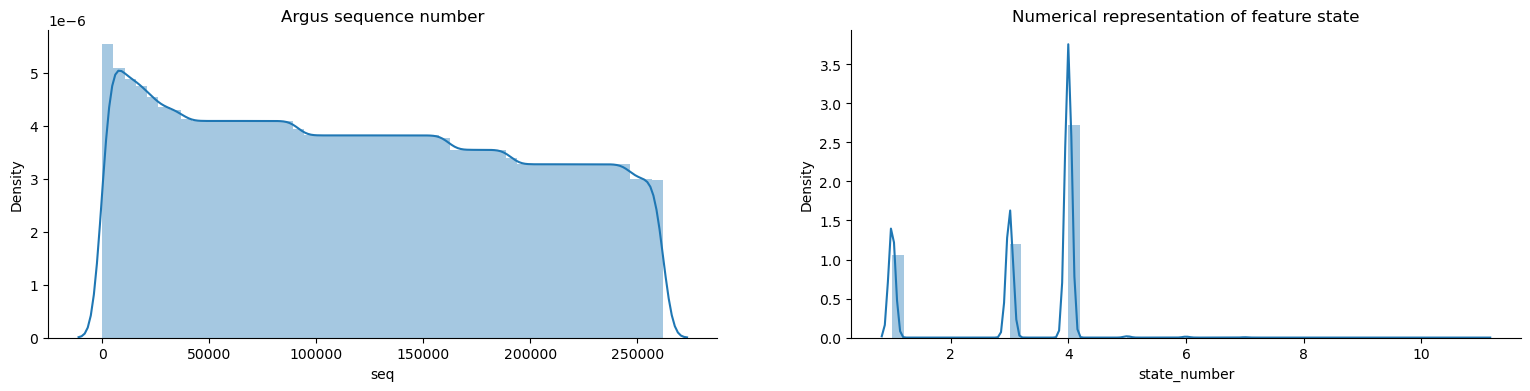

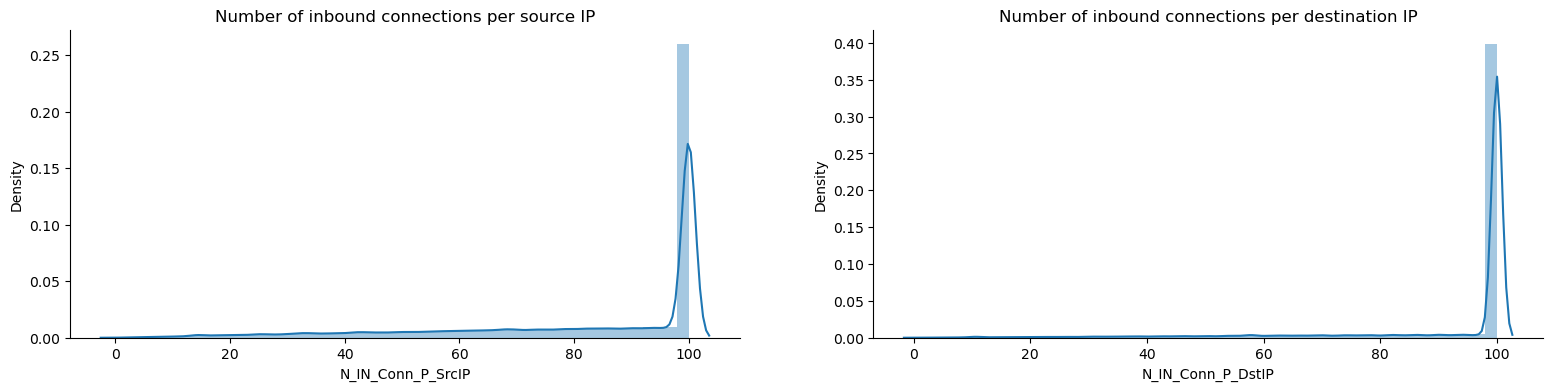

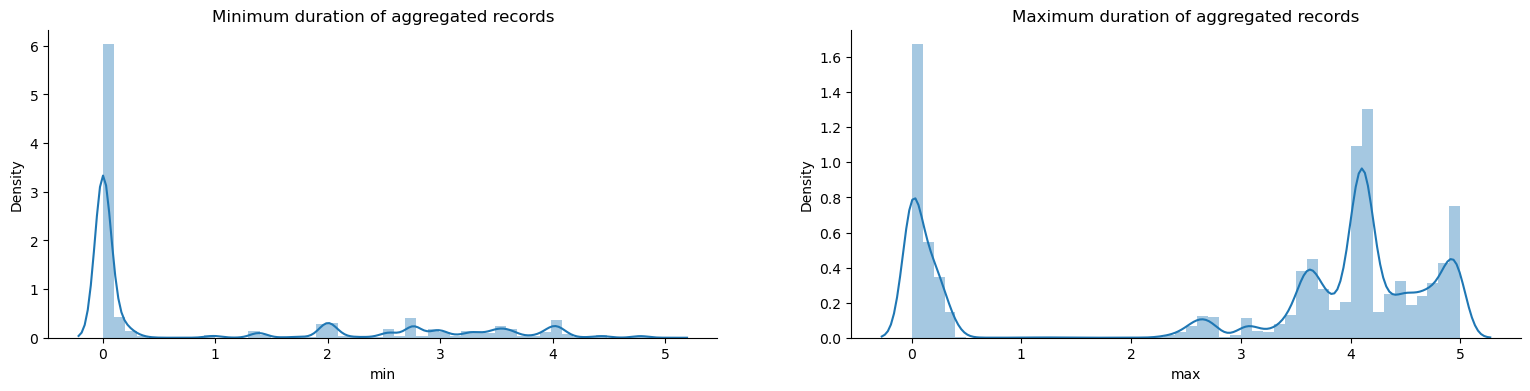

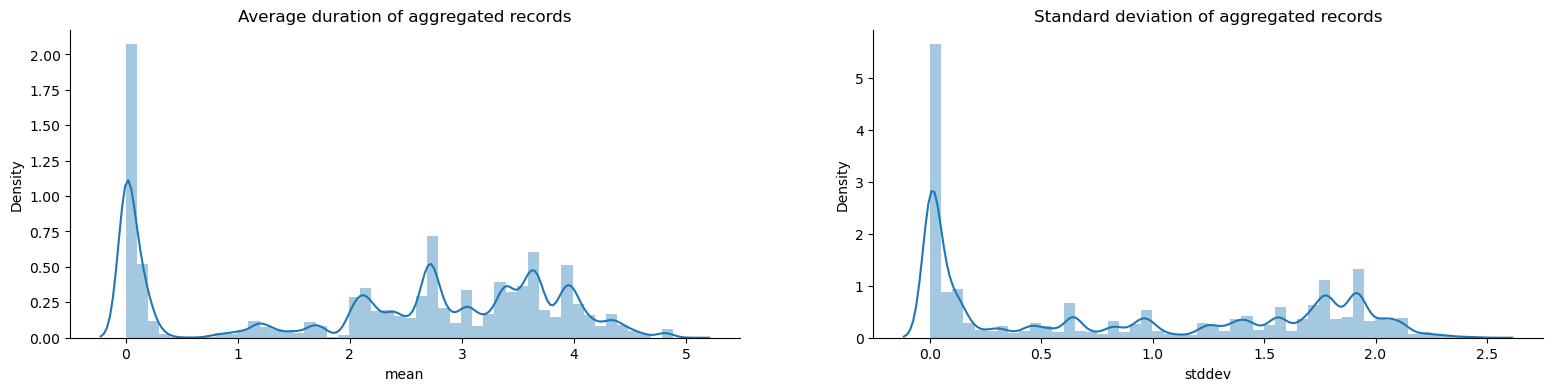

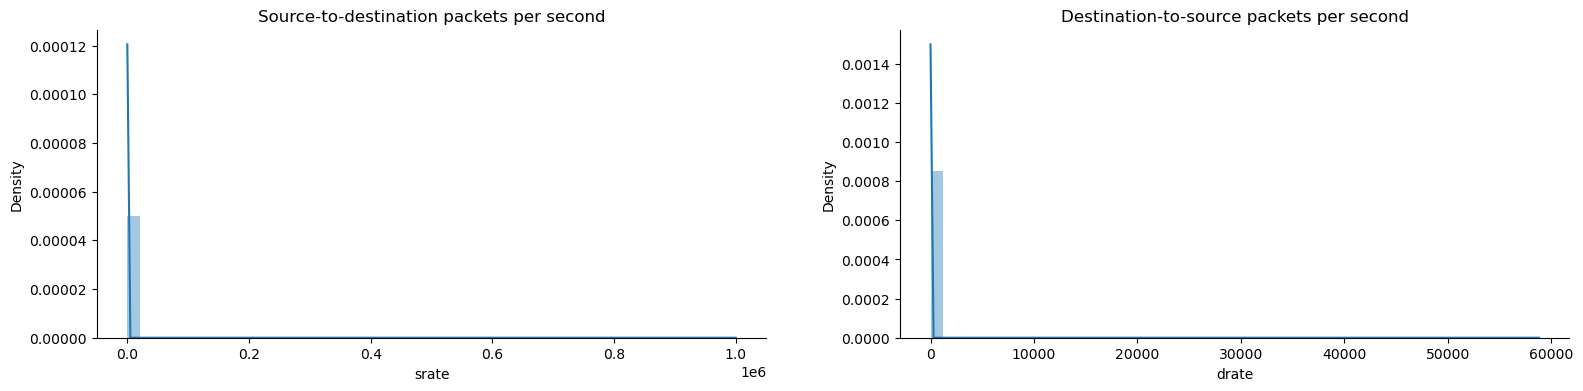

In [7]:
fig, ax1 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['seq'], ax = ax1[0])
ax1[0].set_title("Argus sequence number")
sns.distplot(df['state_number'], ax = ax1[1])
ax1[1].set_title("Numerical representation of feature state")
sns.despine()

fig, ax2 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['N_IN_Conn_P_SrcIP'], ax = ax2[0])
ax2[0].set_title("Number of inbound connections per source IP")
sns.distplot(df['N_IN_Conn_P_DstIP'], ax = ax2[1])
ax2[1].set_title("Number of inbound connections per destination IP")
sns.despine()

fig, ax3 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['min'], ax = ax3[0])
ax3[0].set_title("Minimum duration of aggregated records")
sns.distplot(df['max'], ax = ax3[1])
ax3[1].set_title("Maximum duration of aggregated records")
sns.despine()

fig, ax4 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['mean'], ax = ax4[0])
ax4[0].set_title("Average duration of aggregated records")
sns.distplot(df['stddev'], ax = ax4[1])
ax4[1].set_title("Standard deviation of aggregated records")
sns.despine()

fig, ax5 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['srate'], ax = ax5[0])
ax5[0].set_title("Source-to-destination packets per second")
sns.distplot(df['drate'], ax = ax5[1])
ax5[1].set_title("Destination-to-source packets per second")
sns.despine()

plt.show()

In [10]:
'''import matplotlib.pyplot as plt
import seaborn as sns

# Features to plot and their titles
plot_groups = [
    (['seq', 'state_number'], ["Argus sequence number", "Numerical representation of feature state"]),
    (['N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP'], ["Inbound connections per source IP", "Inbound connections per destination IP"]),
    (['min', 'max'], ["Minimum duration of aggregated records", "Maximum duration of aggregated records"]),
    (['mean', 'stddev'], ["Average duration of aggregated records", "Standard deviation of aggregated records"]),
    (['srate', 'drate'], ["Source-to-destination packets/sec", "Destination-to-source packets/sec"])
]

# Loop over each group and plot
for features, titles in plot_groups:
    fig, axes = plt.subplots(1, 2, figsize=(19, 4))
    for i, (feature, title) in enumerate(zip(features, titles)):
        sns.histplot(df[feature], ax=axes[i], kde=True)
        axes[i].set_title(title)
    sns.despine()
    plt.tight_layout()

plt.show()'''

'import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Features to plot and their titles\nplot_groups = [\n    ([\'seq\', \'state_number\'], ["Argus sequence number", "Numerical representation of feature state"]),\n    ([\'N_IN_Conn_P_SrcIP\', \'N_IN_Conn_P_DstIP\'], ["Inbound connections per source IP", "Inbound connections per destination IP"]),\n    ([\'min\', \'max\'], ["Minimum duration of aggregated records", "Maximum duration of aggregated records"]),\n    ([\'mean\', \'stddev\'], ["Average duration of aggregated records", "Standard deviation of aggregated records"]),\n    ([\'srate\', \'drate\'], ["Source-to-destination packets/sec", "Destination-to-source packets/sec"])\n]\n\n# Loop over each group and plot\nfor features, titles in plot_groups:\n    fig, axes = plt.subplots(1, 2, figsize=(19, 4))\n    for i, (feature, title) in enumerate(zip(features, titles)):\n        sns.histplot(df[feature], ax=axes[i], kde=True)\n        axes[i].set_title(title)\n    sns.despine()\n

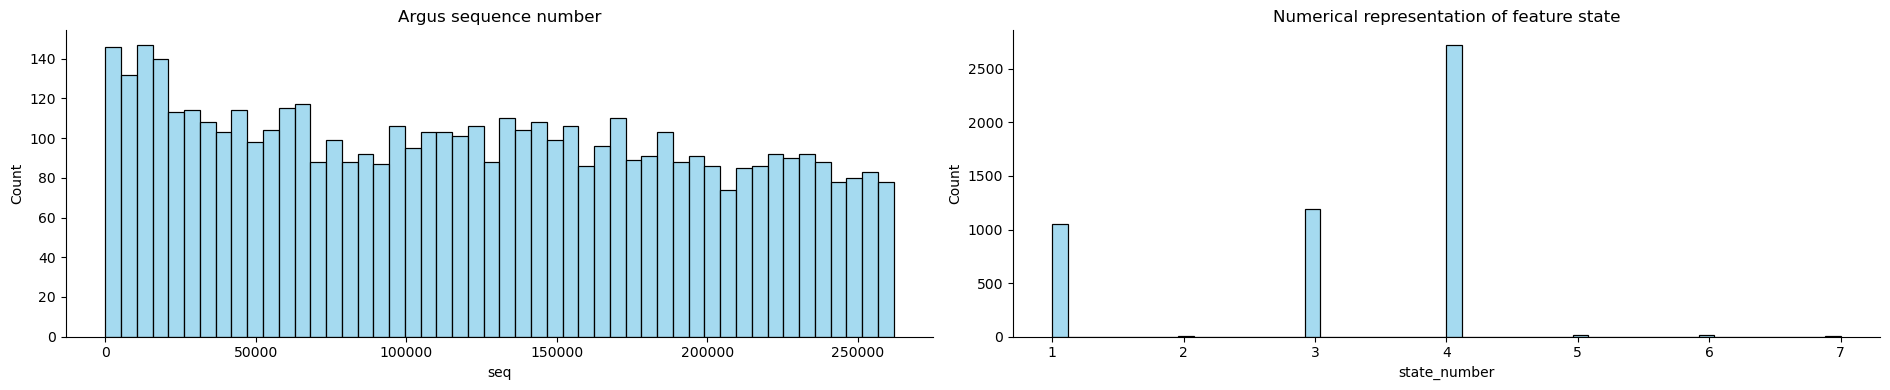

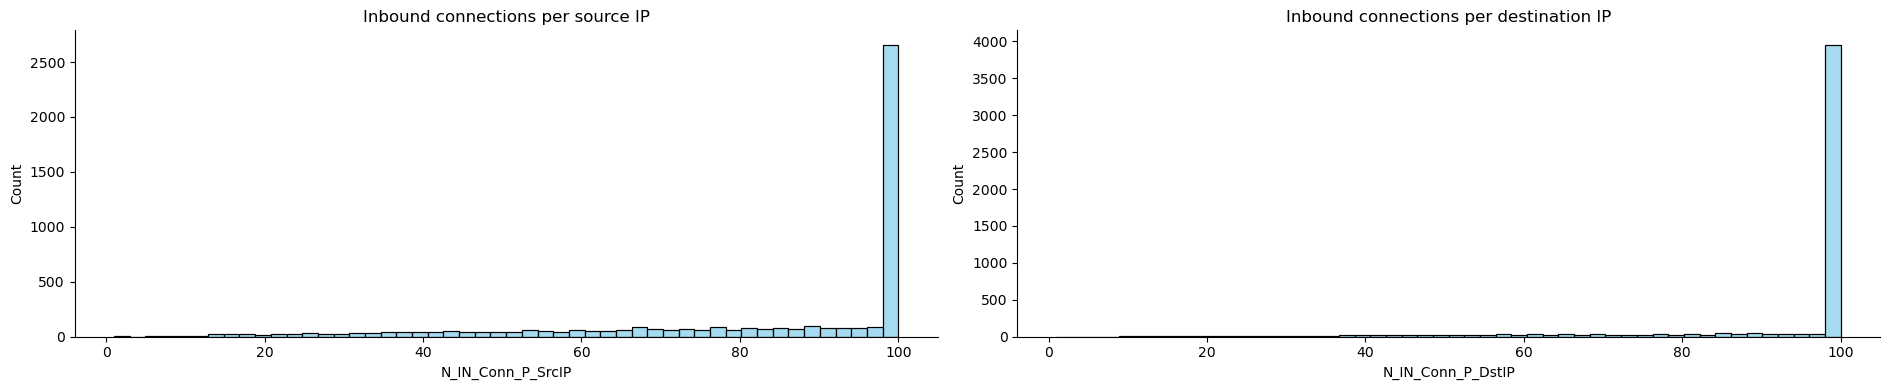

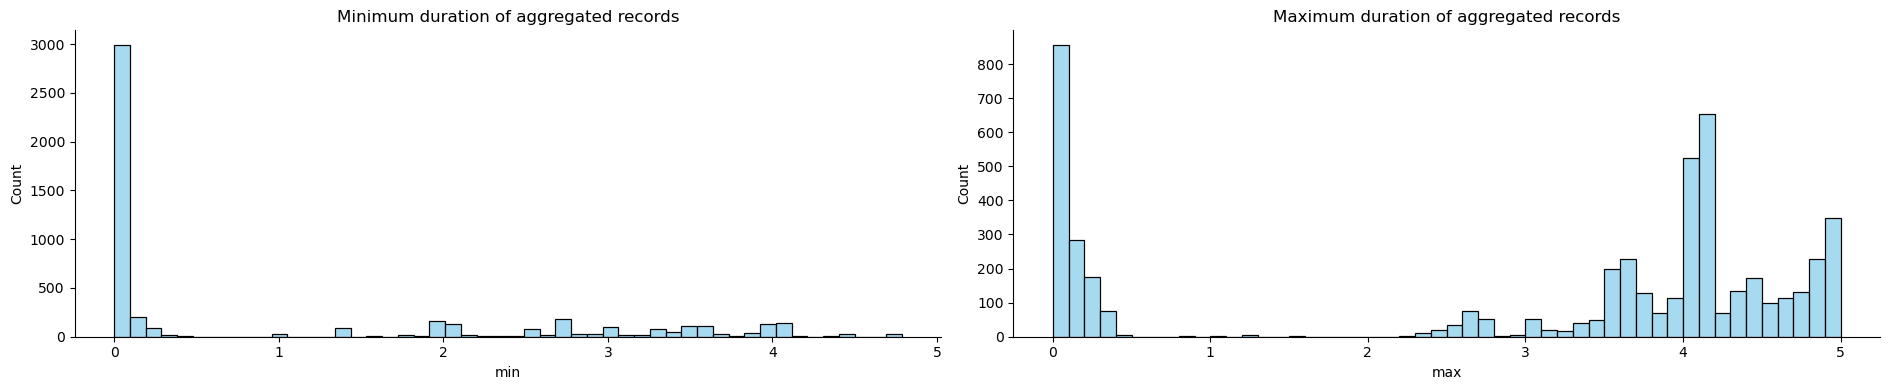

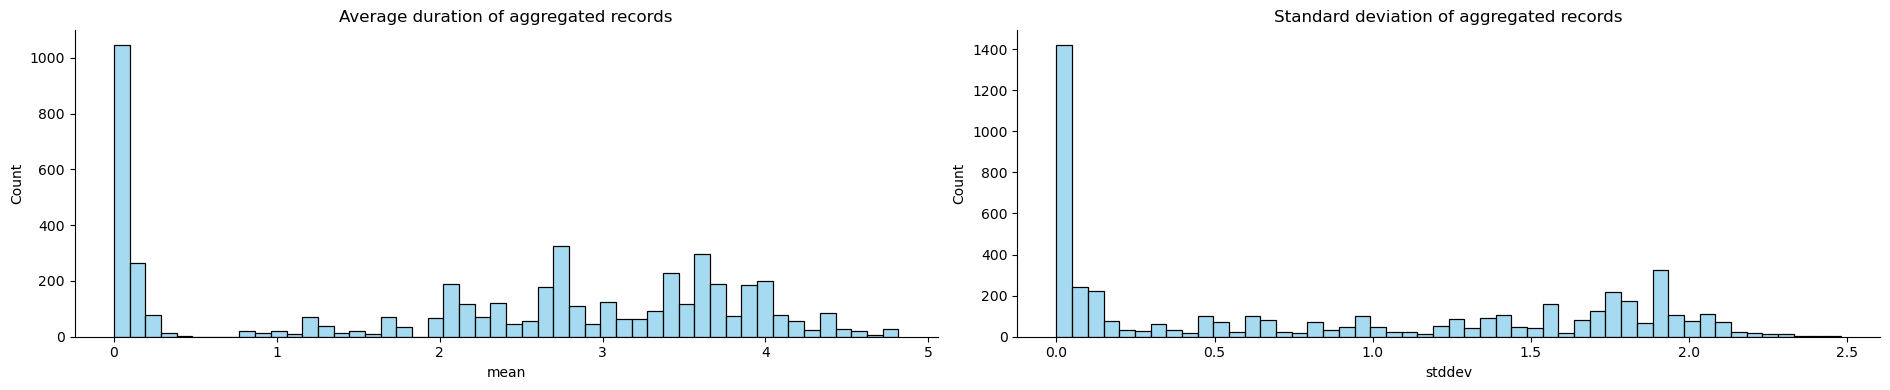

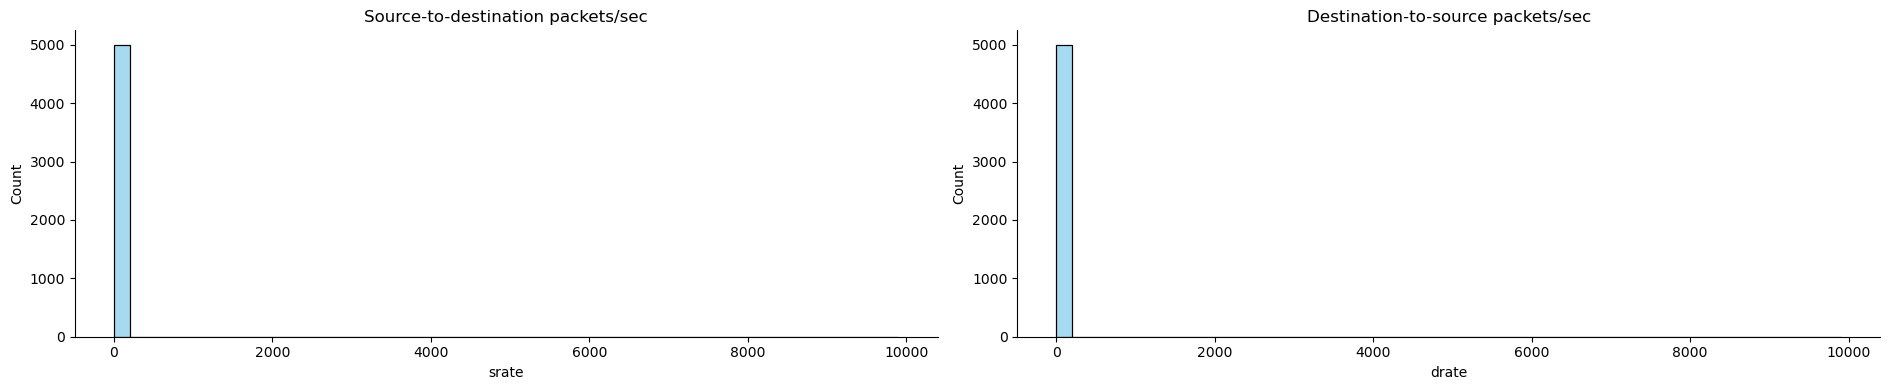

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a sampled subset for plotting
df_sample = df.sample(n=5000, random_state=42)  # adjust n if needed

# Features to plot and their titles
plot_groups = [
    (['seq', 'state_number'], ["Argus sequence number", "Numerical representation of feature state"]),
    (['N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP'], ["Inbound connections per source IP", "Inbound connections per destination IP"]),
    (['min', 'max'], ["Minimum duration of aggregated records", "Maximum duration of aggregated records"]),
    (['mean', 'stddev'], ["Average duration of aggregated records", "Standard deviation of aggregated records"]),
    (['srate', 'drate'], ["Source-to-destination packets/sec", "Destination-to-source packets/sec"])
]

# Loop over each group and plot
for features, titles in plot_groups:
    fig, axes = plt.subplots(1, 2, figsize=(19, 4))
    for i, (feature, title) in enumerate(zip(features, titles)):
        sns.histplot(df_sample[feature], ax=axes[i], kde=False, bins=50, color='skyblue')
        axes[i].set_title(title)
    sns.despine()
    plt.tight_layout()

plt.show()


## Pearson Correlation Matrix

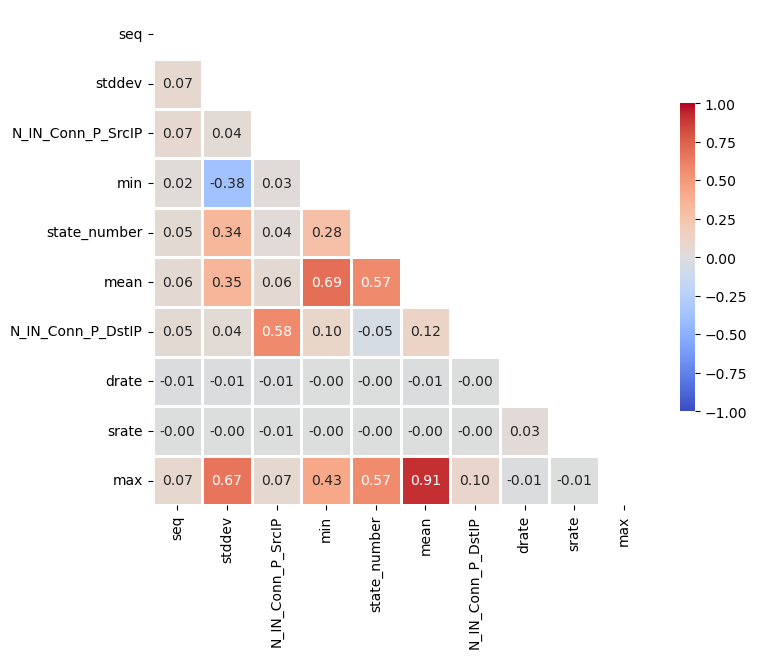

In [11]:
corr=df[feat_keys].corr(method='pearson')

plt.figure(figsize=(8, 8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            cmap="coolwarm", 
            annot=True, 
            fmt=".2f",
            mask=mask, 
            vmax=1, 
            vmin=-1,
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5})
plt.show()

## Feature transformation
Apply transformations if:

Skewness > 1 or < -1 (highly skewed)

Your ML model is sensitive to feature distribution

You can try other transformations too:

log(x + 1)

sqrt(x)

Box-Cox or Yeo-Johnson (auto-optimized)

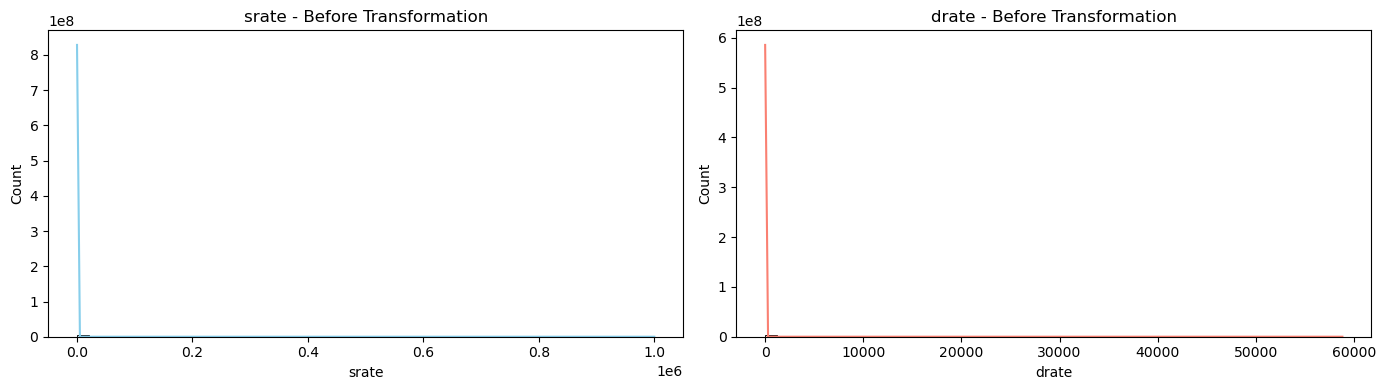

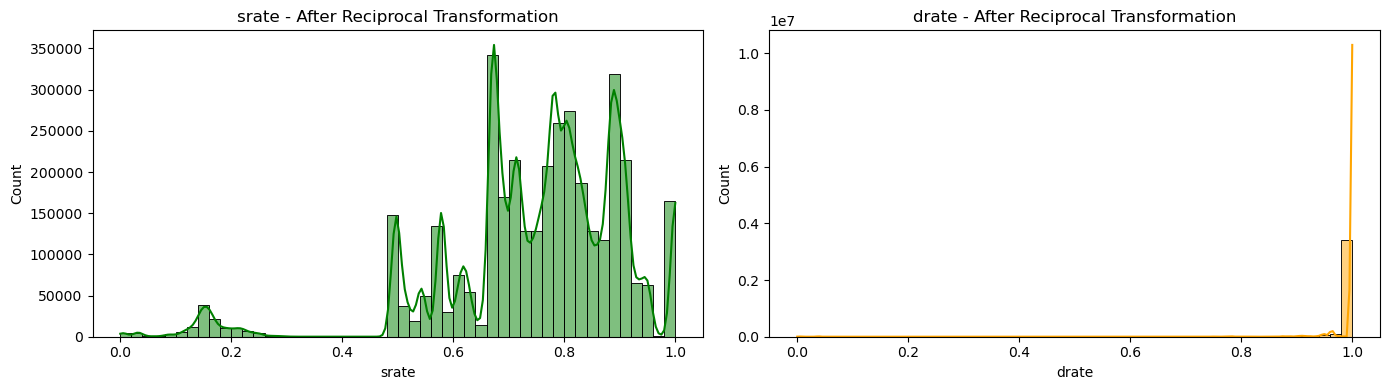

In [12]:
# Make a copy so you preserve the original for comparison
df_vis = df.copy()

# --- BEFORE TRANSFORMATION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_vis['srate'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('srate - Before Transformation')
sns.histplot(df_vis['drate'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('drate - Before Transformation')
plt.tight_layout()
plt.show()

# --- Apply Reciprocal Transformation ---
df_vis['srate'] = df_vis['srate'].apply(lambda x: np.reciprocal(x + 1))
df_vis['drate'] = df_vis['drate'].apply(lambda x: np.reciprocal(x + 1))

# --- AFTER TRANSFORMATION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_vis['srate'], bins=50, kde=True, ax=axes[0], color='green')
axes[0].set_title('srate - After Reciprocal Transformation')
sns.histplot(df_vis['drate'], bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title('drate - After Reciprocal Transformation')
plt.tight_layout()
plt.show()

### np.reciprocal(x + 1))

In [13]:
print('Skewness before transformation: {}'.format(df['srate'].skew()))
df['srate'] = df['srate'].apply(lambda x: np.reciprocal(x + 1)) # the +1 avoids null values exceptions
print('Skewness after transformation: {}'.format(df['srate'].skew()))

print('Skewness before transformation: {}'.format(df['drate'].skew()))
df['drate'] = df['drate'].apply(lambda x: np.reciprocal(x + 1))
print('Skewness after transformation: {}'.format(df['drate'].skew()))

Skewness before transformation: 919.1096733605993
Skewness after transformation: -1.476797646496916
Skewness before transformation: 770.772226120121
Skewness after transformation: -14.9206912989185


### np.log10(x + 1e-5)

In [18]:
print('Skewness before transformation: {}'.format(df['srate'].skew()))
df['srate1'] = df['srate'].apply(lambda x: np.log10(x + 1e-5)) 
print('Skewness after transformation: {}'.format(df['srate1'].skew()))

print('Skewness before transformation: {}'.format(df['drate'].skew()))
df['drate1'] = df['drate'].apply(lambda x: np.log10(x + 1e-5))
print('Skewness after transformation: {}'.format(df['drate1'].skew()))

Skewness before transformation: 919.1096733605993
Skewness after transformation: -3.3001901328408123
Skewness before transformation: 770.772226120121
Skewness after transformation: 3.4732517803936407


### np.sqrt

In [19]:
print('Skewness before transformation: {}'.format(df['srate'].skew()))
df['srate2'] = np.sqrt(df['srate'])
print('Skewness after transformation: {}'.format(df['srate2'].skew()))

print('Skewness before transformation: {}'.format(df['drate'].skew()))
df['drate2'] = np.sqrt(df['drate'])
print('Skewness after transformation: {}'.format(df['drate2'].skew()))

Skewness before transformation: 919.1096733605993
Skewness after transformation: 202.808015203096
Skewness before transformation: 770.772226120121
Skewness after transformation: 84.1997132581105


### Winsorize

In [20]:
print('Skewness before transformation: {}'.format(df['srate'].skew()))
q_hi = df['srate'].quantile(0.99)
df['srate3'] = np.where(df['srate'] > q_hi, q_hi, df['srate'])
print('Skewness after transformation: {}'.format(df['srate2'].skew()))

print('Skewness before transformation: {}'.format(df['drate'].skew()))
q_hi = df['drate'].quantile(0.99)
df['drate3'] = np.where(df['drate'] > q_hi, q_hi, df['drate'])
print('Skewness after transformation: {}'.format(df['drate3'].skew()))

Skewness before transformation: 919.1096733605993
Skewness after transformation: 202.808015203096
Skewness before transformation: 770.772226120121
Skewness after transformation: 5.149996013827867


### Ensamble correction

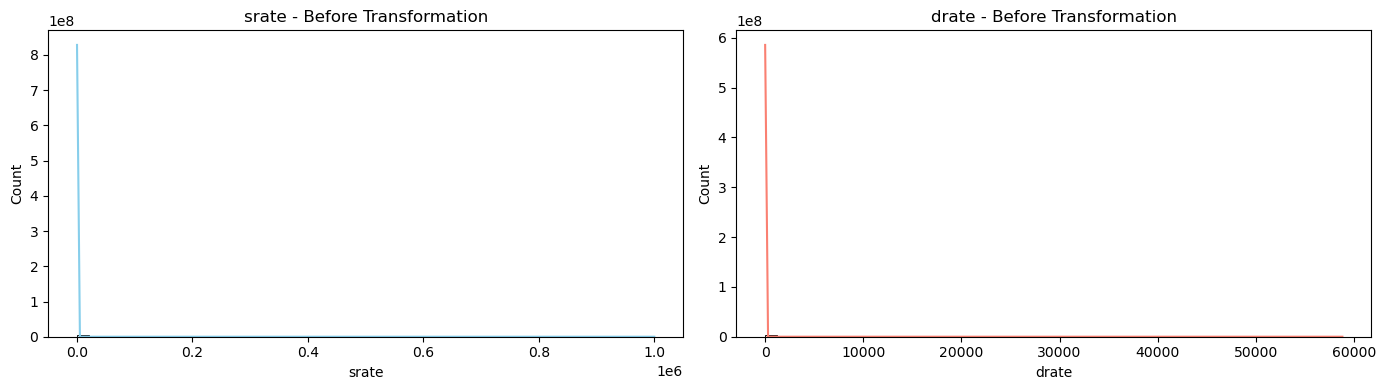

Skewness before transformation: 919.1096733605993
Skewness after transformation: -1.476797646496916
Skewness before transformation: 770.772226120121
Skewness after transformation: 3.4732517803936407


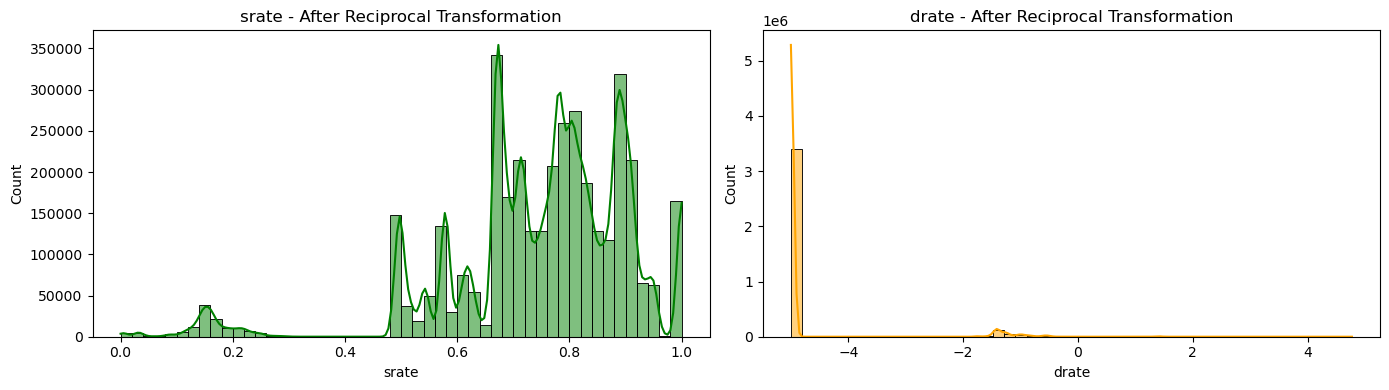

In [26]:
df_vis = df.copy()

# --- BEFORE TRANSFORMATION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_vis['srate'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('srate - Before Transformation')
sns.histplot(df_vis['drate'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('drate - Before Transformation')
plt.tight_layout()
plt.show()

# --- Apply Transformation ---
print('Skewness before transformation: {}'.format(df_vis['srate'].skew()))
df_vis['srate'] = df_vis['srate'].apply(lambda x: np.reciprocal(x + 1))
print('Skewness after transformation: {}'.format(df_vis['srate'].skew()))

print('Skewness before transformation: {}'.format(df_vis['drate'].skew()))
df_vis['drate'] = df_vis['drate'].apply(lambda x: np.log10(x + 1e-5))           
print('Skewness after transformation: {}'.format(df_vis['drate'].skew()))

# --- AFTER TRANSFORMATION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_vis['srate'], bins=50, kde=True, ax=axes[0], color='green')
axes[0].set_title('srate - After Reciprocal Transformation')
sns.histplot(df_vis['drate'], bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title('drate - After Reciprocal Transformation')
plt.tight_layout()
plt.show()

## normalization

In [29]:
scaler = MinMaxScaler()
df[feat_keys] = scaler.fit_transform(df[feat_keys])

df[feat_keys].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
seq,3668522.0,0.462679,0.289058,0.0,2.092780e-01,4.491345e-01,7.052679e-01,1.0
stddev,3668522.0,0.355320,0.321902,0.0,1.202317e-02,3.179701e-01,6.990234e-01,1.0
N_IN_Conn_P_SrcIP,3668522.0,0.823621,0.246438,0.0,6.868687e-01,1.000000e+00,1.000000e+00,1.0
min,3668522.0,0.204306,0.297901,0.0,0.000000e+00,0.000000e+00,4.319146e-01,1.0
state_number,3668522.0,0.213439,0.118697,0.0,2.000000e-01,3.000000e-01,3.000000e-01,1.0
mean,3668522.0,0.447835,0.304649,0.0,3.652575e-02,5.399818e-01,7.156338e-01,1.0
N_IN_Conn_P_DstIP,3668522.0,0.923754,0.183600,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0
drate,3668522.0,0.000008,0.001025,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
srate,3668522.0,0.000003,0.000725,0.0,1.559700e-07,2.837830e-07,4.882010e-07,1.0
max,3668522.0,0.604003,0.372176,0.0,5.612146e-02,8.018224e-01,8.587166e-01,1.0


### PCA

In [30]:
pca = PCA(n_components=10)
df_projected = pca.fit_transform(df[feat_keys])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)

       Explained Variance  Cumulative Variance
PC 1               0.4654               0.4654
PC 2               0.2262               0.6916
PC 3               0.1384               0.8300
PC 4               0.1190               0.9490
PC 5               0.0296               0.9786
PC 6               0.0145               0.9931
PC 7               0.0059               0.9990
PC 8               0.0010               1.0000
PC 9               0.0000               1.0000
PC 10              0.0000               1.0000


In [31]:
# Feature names
features = np.array(feat_keys)

# For each PC, print top contributing original features
for i, component in enumerate(pca.components_[:7]):  # Top 7 PCs
    sorted_idx = np.argsort(np.abs(component))[::-1]  # Sort by magnitude
    print(f"\nTop contributors to PC {i+1}:")
    for j in sorted_idx[:3]:  # Show top 3
        print(f"  {features[j]} (weight: {component[j]:.4f})")



Top contributors to PC 1:
  max (weight: -0.6894)
  mean (weight: -0.5398)
  stddev (weight: -0.3608)

Top contributors to PC 2:
  stddev (weight: -0.6867)
  min (weight: 0.6841)
  mean (weight: 0.2208)

Top contributors to PC 3:
  seq (weight: -0.8867)
  N_IN_Conn_P_SrcIP (weight: -0.3900)
  N_IN_Conn_P_DstIP (weight: -0.2315)

Top contributors to PC 4:
  N_IN_Conn_P_SrcIP (weight: -0.7609)
  N_IN_Conn_P_DstIP (weight: -0.4590)
  seq (weight: 0.4554)

Top contributors to PC 5:
  N_IN_Conn_P_DstIP (weight: -0.8296)
  N_IN_Conn_P_SrcIP (weight: 0.5062)
  state_number (weight: 0.2288)

Top contributors to PC 6:
  state_number (weight: 0.9434)
  N_IN_Conn_P_DstIP (weight: 0.2060)
  max (weight: -0.1676)

Top contributors to PC 7:
  mean (weight: 0.7949)
  min (weight: -0.4486)
  max (weight: -0.3229)


In [38]:
pcaselect_df = pd.DataFrame(data=df_projected[:,:2], columns=[pcs[:2]])
pcaselect_labelled_df = pd.concat([pcaselect_df, df['attack']], axis=1, ignore_index=True)
pcaselect_labelled_df.columns = [*pcs[:2], 'attack']


In [40]:
pcaselect_labelled_df

,PC 1,PC 2,attack
0,0.863252,0.067273,1
1,0.964940,0.056783,1
2,0.865586,0.068447,1
3,0.865747,0.068528,1
4,0.865906,0.068608,1
...,...,...,...
3668517,0.957859,0.064460,1
3668518,0.961668,0.062395,1
3668519,0.026722,0.533380,1
3668520,0.977683,0.056793,1


PCA transforms the features, but it does not change the row order. Each row in the PCA result (df_projected) still corresponds exactly to the same row in the original DataFrame df.

That means:

Row	Original Features → PCA	attack
0	PC1, PC2, PC3, PC4	1
1	PC1, PC2, PC3, PC4	1
2	PC1, PC2, PC3, PC4	0

### ADD 4 more PC features

X has 4 features (from PCA)

t-SNE transforms those into just 2 dimensions

This helps you visualize the data in 2D

Each row of X_transformed is now: [new_x1, new_x2]

So t-SNE creates a 2D map that tries to place similar data points near each other in a way that preserves their clustering patterns.

C:\Users\linz\AppData\Local\Temp\ipykernel_26360\1841808106.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_normal.append(df_malicious).sample(frac=1)
C:\Users\bojun\Conda\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\bojun\Conda\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


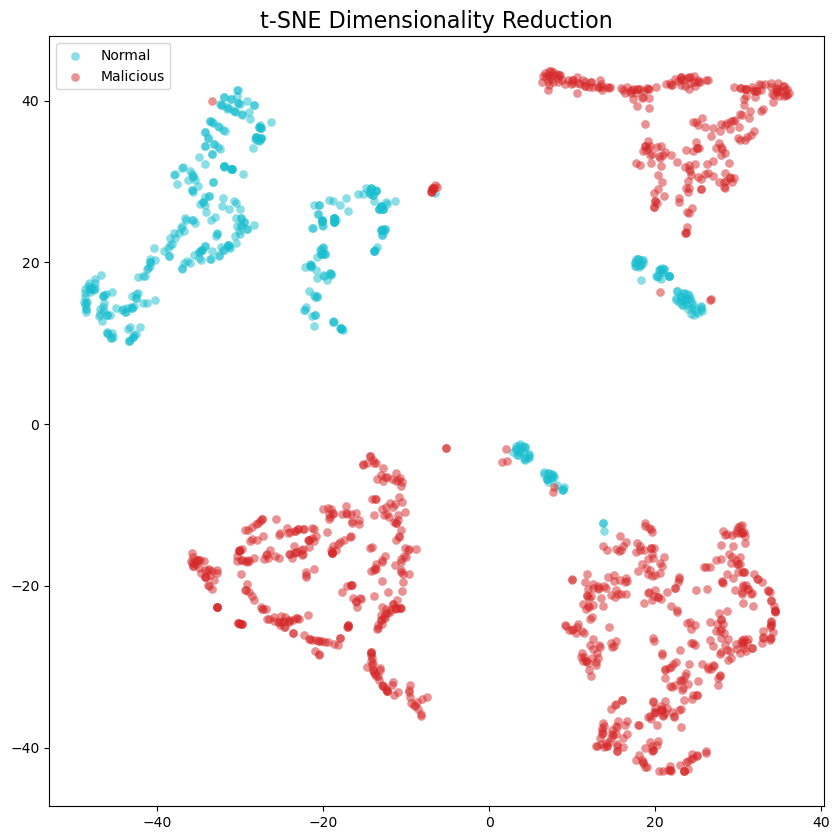

In [41]:
pcaselect_df = pd.DataFrame(data=df_projected[:,:4], columns=pcs[:4])

pcaselect_labelled_df = pd.concat([pcaselect_df, df['attack']], axis=1, ignore_index=True)
pcaselect_labelled_df.columns = [*pcs[:4], 'attack']

df_normal = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 0]
df_malicious  = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 1].sample(1000)

df_new = df_normal.append(df_malicious).sample(frac=1)
X = df_new[pcs[:4]].values
y = df_new['attack'].values

tsne = TSNE(n_components=2, random_state=37)
X_transformed = tsne.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.title("t-SNE Dimensionality Reduction", fontsize = 16)
plt.scatter(X_transformed[y == 0, 0], X_transformed[y == 0, 1], label="Normal", alpha=0.5, linewidth=0.15, c='#17becf')
plt.scatter(X_transformed[y == 1, 0], X_transformed[y == 1, 1], label="Malicious", alpha=0.5, linewidth=0.15, c='#d62728')
plt.legend()
plt.show()

C:\Users\linz\AppData\Local\Temp\ipykernel_26360\4075439758.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_normal.append(df_malicious).sample(frac=1)
C:\Users\bojun\Conda\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\bojun\Conda\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


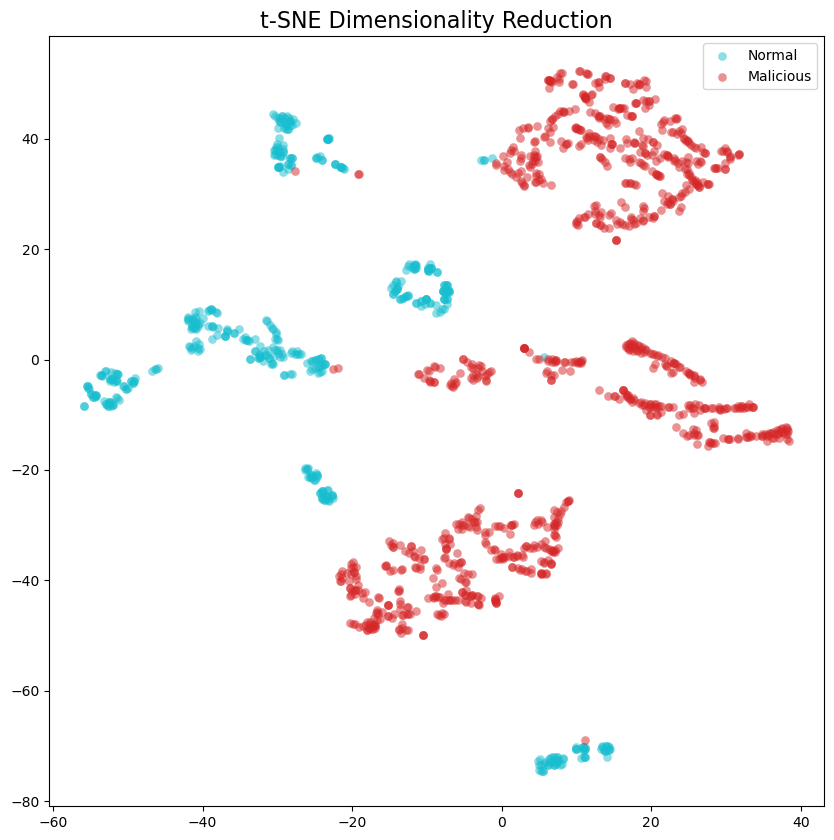

In [43]:
pcaselect_df = pd.DataFrame(data=df_projected[:,:8], columns=pcs[:8])

pcaselect_labelled_df = pd.concat([pcaselect_df, df['attack']], axis=1)
pcaselect_labelled_df.columns = [*pcs[:8], 'attack']

df_normal = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 0]
df_malicious  = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 1].sample(1000)

df_new = df_normal.append(df_malicious).sample(frac=1)
X = df_new[pcs[:8]].values
y = df_new['attack'].values

tsne = TSNE(n_components=2, random_state=37)
X_transformed = tsne.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.title("t-SNE Dimensionality Reduction", fontsize = 16)
plt.scatter(X_transformed[y == 0, 0], X_transformed[y == 0, 1], label="Normal", alpha=0.5, linewidth=0.15, c='#17becf')
plt.scatter(X_transformed[y == 1, 0], X_transformed[y == 1, 1], label="Malicious", alpha=0.5, linewidth=0.15, c='#d62728')
plt.legend()
plt.show()

2. Why more PCs can make the t-SNE plot worse
Using 4 PCs	Using 8 PCs
Captures 95% variance	Captures 100% (but last 5% may be noise)
Fewer dimensions → cleaner map	More dimensions → t-SNE gets confused
Clearer separation (sometimes)	Messier clusters (possible overlap)

## Training data

In [85]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

In [87]:
X_raw = df[feat_keys].values
y_raw = df['attack'].values

pca = PCA(n_components=4)
df_projected = pca.fit_transform(X_raw)
pcs = [f'PC {i}' for i in range(1, 5)]

# --- Step 2: Build PCA DataFrame with Labels ---
pcaselect_df = pd.DataFrame(data=df_projected[:, :4], columns=pcs[:4])
pcaselect_labelled_df = pd.concat([pcaselect_df, pd.Series(y_raw, name='attack')], axis=1)

# --- Step 3: Balance the Dataset (Optimized Version) ---
# Take all normal samples
df_normal = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 0]
# Sample 1000 malicious samples
df_malicious = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 1].sample(1000, random_state=37)

# Combine and shuffle
df_balanced = pd.concat([df_normal, df_malicious], ignore_index=True).sample(frac=1, random_state=37)

# --- Step 4: Prepare Features and Labels ---
X = df_balanced[pcs[:4]].values
y = df_balanced['attack'].values

# --- Step 5: Split Data ---
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.3, random_state=37)

# --- Step 6: Train Models ---
modelLR = LogisticRegression(max_iter=1000)
modelSVM = SVC()
modelRF = RandomForestClassifier()
modelMLP = MLPClassifier(max_iter=200)

modelLR.fit(X_train_pca, y_train_pca)
modelSVM.fit(X_train_pca, y_train_pca)
modelRF.fit(X_train_pca, y_train_pca)
modelMLP.fit(X_train_pca, y_train_pca)

# --- Step 7: Predict ---
predictions = {
    "Logistic Regression (PCA-4)": modelLR.predict(X_test_pca),
    "SVM (PCA-4)": modelSVM.predict(X_test_pca),
    "Random Forest (PCA-4)": modelRF.predict(X_test_pca),
    "MLP (PCA-4)": modelMLP.predict(X_test_pca)
}

# --- Step 8: Evaluate ---
summary = []
for model, y_pred in predictions.items():
    metrics = classification_report(y_test_pca, y_pred, output_dict=True)
    summary.append({
        "Model": model,
        "Accuracy": accuracy_score(y_test_pca, y_pred),
        "Precision": metrics["weighted avg"]["precision"],
        "Recall": metrics["weighted avg"]["recall"],
        "F1-score": metrics["weighted avg"]["f1-score"]
    })

summary_df = pd.DataFrame(summary).set_index("Model")
print(summary_df.round(4))

                             Accuracy  Precision  Recall  F1-score
Model                                                             
Logistic Regression (PCA-4)    0.9730     0.9751  0.9730    0.9733
SVM (PCA-4)                    0.9730     0.9751  0.9730    0.9733
Random Forest (PCA-4)          0.9842     0.9847  0.9842    0.9843
MLP (PCA-4)                    0.9730     0.9751  0.9730    0.9733


C:\Users\bojun\Conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Hyperparameter tuning priorize the features

In [44]:
# First train and label data created. 
train_data, label_data = df.iloc[:,:-1], df.iloc[:,-1]

#Convert to matrix
data_dmatrix = xgb.DMatrix(data=train_data, label= label_data)

#Split data randomly to train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(train_data, label_data, test_size=0.3, random_state=37)

grid_param = {'objective':['binary:logistic'],
              'n_estimators': [50, 500],
              'learning_rate': [0.05],
              'min_child_weight': [8, 10, 12],
              'max_depth': [4, 6, 8],
              'seed': [1337]}

# Building Grid Search algorithm with cross-validation and F1 score.
grid_search = GridSearchCV(estimator=XGBClassifier(),
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

# Lastly, finding the best parameters.

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_  
print(best_parameters)

{'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 500, 'objective': 'binary:logistic', 'seed': 1337}


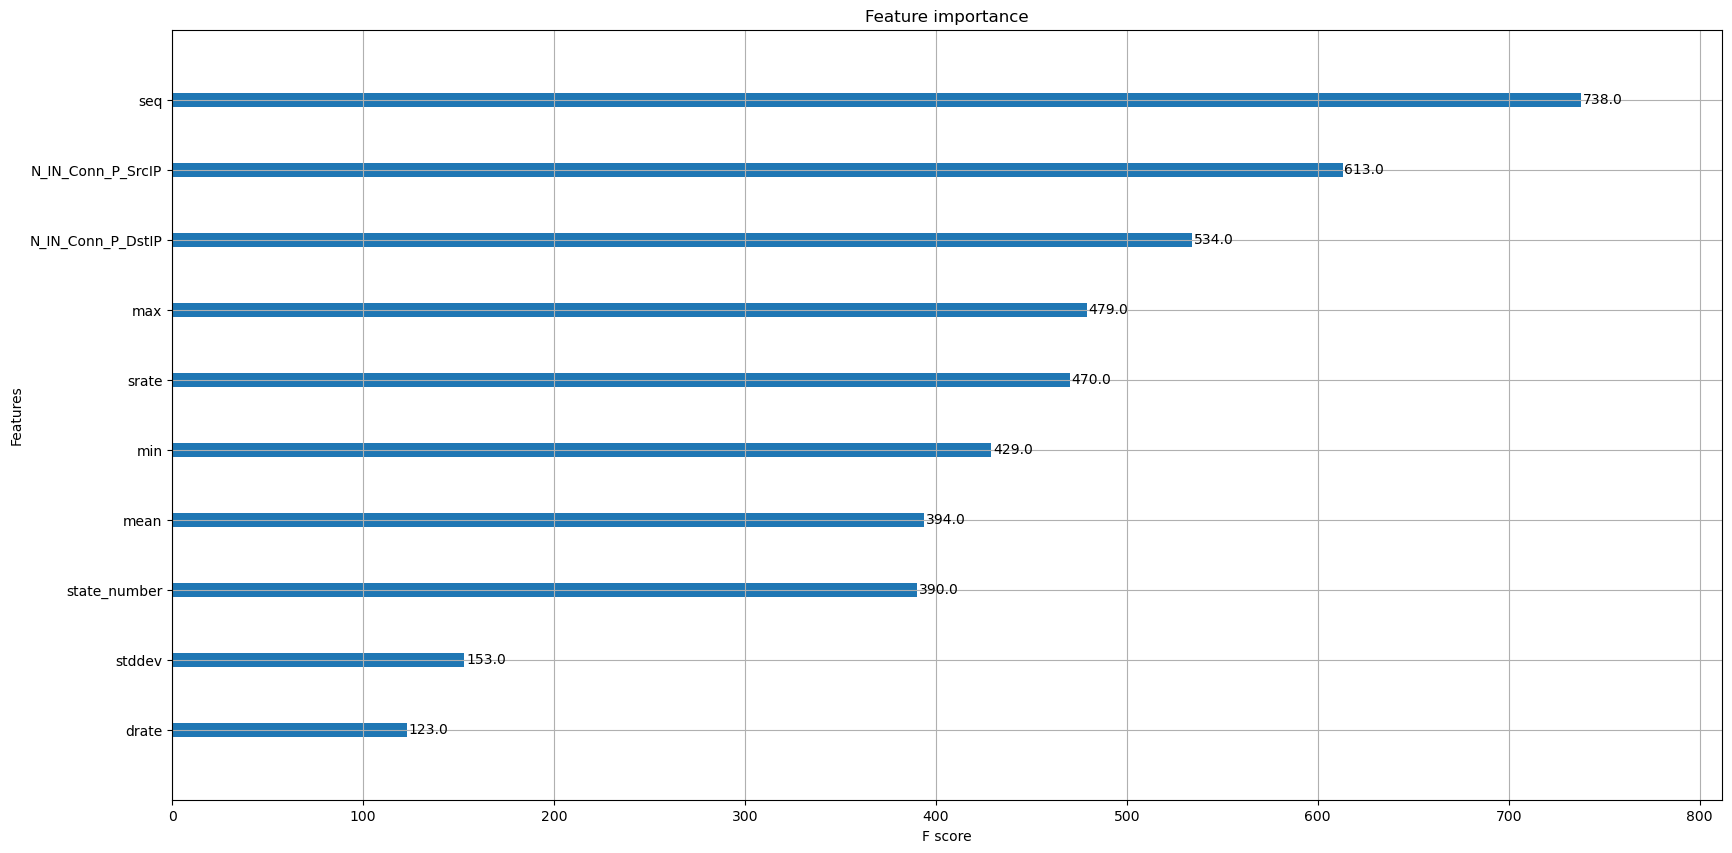

In [120]:
params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.3,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 8,
    'seed': 1337,
    'eval_metric': 'logloss'  # or 'auc', optional but recommended
}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=500)


#Feature importance graph
plt.rcParams['figure.figsize'] = [20, 10]
xgb.plot_importance(xg_reg)
plt.show()

In [123]:
# ✅ Step 1: Get feature importance by gain
importance_gain = xg_reg.get_score(importance_type='gain')

# ✅ Step 2: Convert to DataFrame and sort
importance_df = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['Gain'])
importance_df.index.name = 'Feature'
importance_df = importance_df.sort_values(by='Gain', ascending=False).reset_index()

# ✅ Step 3: Print top 10 features
print("Top 10 features based on XGBoost Gain:")
for i, row in importance_df.head(10).iterrows():
    print(f"{i+1}. {row['Feature']} - Gain: {row['Gain']:.4f}")

Top 10 features based on XGBoost Gain:
1. N_IN_Conn_P_DstIP - Gain: 29.7468
2. state_number - Gain: 25.8117
3. srate - Gain: 18.3331
4. min - Gain: 13.9271
5. N_IN_Conn_P_SrcIP - Gain: 13.4279
6. max - Gain: 12.5842
7. stddev - Gain: 12.5188
8. drate - Gain: 11.3419
9. mean - Gain: 11.1302
10. seq - Gain: 9.8473


✅ 1. What Method Does xgb.plot_importance() Use to Prioritize Features?
The method used by xgb.plot_importance() is usually one of these:

Importance Type	Description
weight (default)	Number of times a feature is used in any split across all trees.
gain	Average gain (improvement in purity) from splits using this feature.
cover	Average number of samples affected by splits using this feature.

🔹 Default is 'weight', unless you explicitly change it:

python
Copy
Edit
xgb.plot_importance(xg_reg, importance_type='gain')
🧠 In short:
xgb.plot_importance() shows which features the trained model actually used and how important they were to predictive power.

✅ 2. Why use both Pearson correlation and XGBoost feature importance?
You're asking:

“We already looked at correlation. Why evaluate feature importance again?”

Because they serve different purposes:

Purpose	Pearson Correlation	XGBoost Feature Importance
Measures	Linear relationship between pairs of features	Predictive contribution of features to the target
Useful for	Removing redundant features	Understanding model decisions
Model-aware?	❌ No	✅ Yes (based on trained model)
Can detect non-linear effects?	❌ No	✅ Yes

🔍 Example:
feature A and feature B might be highly correlated → redundant → consider removing one.

But feature C might be weakly correlated with the target, yet very useful in XGBoost due to nonlinear interactions.

✅ So:
Use correlation to find redundancy between features.

Use XGBoost importance to find what helps your model predict better.

✅ 3. Why use feature selection after PCA?
Great question. Here's the nuance:

First: What PCA does
PCA transforms your original features into uncorrelated components (PC1, PC2, ...)

These are linear combinations of your original features.

You lose direct interpretability: e.g., PC1 ≠ srate, it's a mix.

So if you use PCA as features:
You're working with abstract components that can’t be interpreted directly.

You don’t need to rank original features anymore.

BUT...

If you don’t use PCA for your model, and train on original features, then you still need to know:
Which original features are most useful?



✅ 1. Does XGBoost Feature Importance Use Entropy?
No — not exactly entropy, but you’re close.

XGBoost is a gradient boosting decision tree model, and it uses a concept similar to entropy called “gain” (also known as information gain), which is based on reduction in loss function, not Shannon entropy.

Let me explain:

When a tree splits a node:
It tries to reduce impurity or increase predictive power.

In classification trees, this is similar to information gain (entropy or Gini).

But XGBoost optimizes a gradient-based loss function, like log loss for binary classification.

So:

XGBoost Split Quality Is Based On	Not Exactly
Gain in model performance	Shannon entropy (used in ID3 / info gain trees)

✅ You can think of it as:

"XGBoost chooses features that improve the model’s predictions most, based on loss reduction — not raw entropy."

✅ 2. Pearson vs. XGBoost for Feature Ranking
Yes — your understanding is correct.

🔍 Pearson correlation:
Measures linear relationship between 2 variables.

Values near +1 or -1 indicate strong linear relationship.

It doesn't tell you if a feature helps predict the label, only if it's linearly related.

🔍 XGBoost feature importance:
Model-based and data-driven.

Captures linear + nonlinear patterns.

Shows which features actually improve predictions.

✅ So yes:

In most practical ML cases, XGBoost feature importance is much more useful for identifying relevant features than Pearson alone.

📌 Use Pearson for data exploration and removing redundancy, but trust XGBoost for predictive importance.

✅ 3. Can I Choose PCA or XGBoost for Feature Reduction?
Yes — and here's how to decide:

Option	When to Use	Pros	Cons
PCA	When you want to reduce dimensionality quickly, or features are heavily correlated	Fast, removes redundancy, improves some models	Loses feature interpretability (PCs are not original features)
XGBoost Feature Selection	When you want to know which original features matter most for prediction	Preserves interpretability, good for model insights

In [47]:
df_model = df.drop(['mean'], axis=1)

In [48]:
df_model

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,0.000031,0.027599,0.747475,0.000000e+00,0.0,0.959596,2.467022e-04,5.668620e-07,2.756361e-02,1
1,0.000034,0.000000,0.010101,2.630273e-05,0.1,0.000000,0.000000e+00,0.000000e+00,2.620001e-05,1
2,0.000038,0.025831,0.747475,0.000000e+00,0.0,0.959596,2.635904e-04,5.675490e-07,2.579761e-02,1
3,0.000042,0.025709,0.747475,0.000000e+00,0.0,0.959596,2.648429e-04,5.675700e-07,2.567561e-02,1
4,0.000046,0.025588,0.747475,0.000000e+00,0.0,0.959596,2.660948e-04,5.676300e-07,2.555481e-02,1
...,...,...,...,...,...,...,...,...,...,...
3668517,0.000305,0.000000,0.181818,2.643324e-03,0.0,0.181818,2.582606e-03,1.519180e-04,2.633001e-03,1
3668518,0.000309,0.000000,0.181818,1.152501e-04,0.0,0.181818,5.923345e-02,3.484321e-03,1.148000e-04,1
3668519,0.000317,0.000000,0.181818,5.771145e-01,0.5,0.181818,9.463168e-05,4.522837e-06,5.748605e-01,1
3668520,0.000320,0.000000,0.020202,6.023527e-07,0.0,0.000000,0.000000e+00,0.000000e+00,6.000001e-07,1


## Undersampling
Prior to building the models, we apply undersampling to the data in order to rebalance it slightly. We use one of the most common ways of dealing with imbalanced data, which is the undersampling method. It decreases the number of datapoints of the dominant label, in our case the attack = 1 label. In this project, we retain a sample of 10 000 malicious dataflows.

In [49]:
data_us_malicious = df_model[df_model['attack'] == 1].sample(10000)
data_us_normal = df_model[df_model['attack'] == 0]
data_us = data_us_malicious.append(data_us_normal, ignore_index=True)

C:\Users\linz\AppData\Local\Temp\ipykernel_26360\3947605323.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_us = data_us_malicious.append(data_us_normal, ignore_index=True)


In [103]:
data_us

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,0.398530,0.719151,1.000000,0.000000,0.3,1.000000,0.000000,4.467160e-07,0.899745,1
1,0.011762,0.037603,1.000000,0.000533,0.0,1.000000,0.000002,3.332660e-07,0.038086,1
2,0.847615,0.797988,0.838384,0.000000,0.2,1.000000,0.000000,1.396360e-07,0.796956,1
3,0.824565,0.188382,0.989899,0.810061,0.3,1.000000,0.000000,4.534800e-07,0.995035,1
4,0.069932,0.497957,0.303030,0.000000,0.3,0.303030,0.000000,3.072700e-07,0.544261,1
...,...,...,...,...,...,...,...,...,...,...
10472,0.014519,0.000000,0.737374,0.058925,0.1,0.010101,0.000000,0.000000e+00,0.058695,0
10473,0.014523,0.000000,0.737374,0.058630,0.1,0.010101,0.000000,0.000000e+00,0.058401,0
10474,0.014546,0.000000,0.737374,0.055797,0.1,0.000000,0.000000,0.000000e+00,0.055579,0
10475,0.014549,0.000000,0.737374,0.056369,0.1,0.010101,0.000000,0.000000e+00,0.056148,0


In [104]:
model_train, model_label = data_us.iloc[:,:-1], data_us.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(model_train, model_label, test_size=0.3, random_state=37)

## Model

### Logistic Regression

In [52]:
modelLR = LogisticRegression(
    solver='sag', 
    class_weight='balanced',
    max_iter=500, 
    random_state=37
)

### Support Vector Machine

In [53]:
modelSVM = svm.SVC(
    probability=True,
    max_iter=3000,
    class_weight='balanced',
    kernel='rbf',
    random_state=37
)

### Random Forest


In [54]:
modelRF = RandomForestClassifier(
    n_estimators=500, 
    criterion = 'gini', 
    max_depth = 4, 
    class_weight='balanced', 
    random_state=37
)

### Neural Network - Multilayer Perceptron

In [55]:
modelMLP = MLPClassifier(
    solver='lbfgs', 
    activation='logistic', 
    hidden_layer_sizes=(256,),
    learning_rate='constant', 
    max_iter=500,
    random_state=37
)

### Neural Network - Multilayer Perceptron 3 (refined with Keras)


In [71]:
# class SkMetrics(Callback):
#     def on_train_begin(self, logs={}):
#         self.confusion = []
#         self.precision = []
#         self.recall = []
#         self.f1s = []      

#     def on_epoch_end(self, epoch, logs={}):
#         score = np.asarray(self.model.predict(self.validation_data[0]))
#         predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
#         targ = self.validation_data[1]
        
#         self.confusion.append(confusion_matrix(targ, predict))
#         self.precision.append(precision_score(targ, predict))
#         self.recall.append(recall_score(targ, predict))
#         self.f1s.append(f1_score(targ, predict))

from keras.callbacks import Callback

# class SkMetrics(Callback):
#     def __init__(self, validation_data):
#         super(SkMetrics, self).__init__()
#         self.validation_data = validation_data

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         X_val, y_val = self.validation_data
#         y_pred = np.round(self.model.predict(X_val))

#         from sklearn.metrics import precision_score, recall_score, f1_score
#         precision = precision_score(y_val, y_pred)
#         recall = recall_score(y_val, y_pred)
#         f1 = f1_score(y_val, y_pred)

#         print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        
class SkMetrics(Callback):
    def __init__(self, validation_data):
        super(SkMetrics, self).__init__()
        self.validation_data = validation_data
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []   

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        X_val, y_val = self.validation_data
        y_pred = (self.model.predict(X_val) > 0.5).astype("int32").flatten()

        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        self.confusion = confusion_matrix(y_val, y_pred)  # <-- save confusion matrix

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        
modelMLP3 = Sequential()
modelMLP3.add(Dense(30, activation='relu', input_shape=(9,)))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(40, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(40, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(60, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(80, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(80, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(90, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(1, activation='sigmoid'))
modelMLP3.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

C:\Users\bojun\Conda\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model training

In [72]:
start_time = time()
modelLR.fit(X_train, y_train)
print('Logistic Regression model trained in', round(time() - start_time, 0), 's')

start_time = time()
modelSVM.fit(X_train, y_train)
print('SVM model trained in', round(time() - start_time, 0), 's')

start_time = time()
modelRF.fit(X_train, y_train)
print('Random Forest model trained in', round(time() - start_time, 0), 's')

start_time = time()
modelMLP.fit(X_train, y_train)
print('Multilayer Perceptron model trained in', round(time() - start_time, 0), 's')

from sklearn.utils import class_weight

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: class_weights_array[0], 1: class_weights_array[1]}

skmetricsMLP3 = SkMetrics(validation_data=(X_test, y_test))

start_time = time()
modelMLP3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=25,
    callbacks=[skmetricsMLP3],
    class_weight=class_weights_dict,
    validation_data=(X_test, y_test),
    verbose=0,
    shuffle=True
)
#print('Multilayer Perceptron Model 3 trained in', round(time() - start_time), 's')

Logistic Regression model trained in 0.0 s
SVM model trained in 0.0 s
Random Forest model trained in 1.0 s
Multilayer Perceptron model trained in 1.0 s
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Epoch 1: Precision=0.9593, Recall=1.0000, F1=0.9792
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
Epoch 2: Precision=0.9764, Recall=0.9997, F1=0.9879
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
Epoch 3: Precision=0.9901, Recall=0.9967, F1=0.9934
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
Epoch 4: Precision=0.9990, Recall=0.9821, F1=0.9905
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
Epoch 5: Precision=0.9997, Recall=0.9662, F1=0.9826
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
Epoch 6: Precision=1.0000, Recall=0.9629, F1=0.9811
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
Epoch 7: Precision=1.0000, Recall=0.9552, F1=0.9771
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
Epoch 8: Precision=1.0000, Recall=0.9456, F1=0.9721
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
Epoch 9: Precision=1.0000, Recall=0.9436, F1=0.9710
99/99 ━━━━━

In [74]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',       # or 'val_f1' if you're tracking F1 manually
    patience=5,
    restore_best_weights=True
)

modelMLP3.fit(
    X_train, y_train,
    epochs=50,                # Use a higher value to allow early stopping to work
    batch_size=25,
    callbacks=[skmetricsMLP3, early_stop],  # Include both callbacks here
    class_weight=class_weights_dict,
    validation_data=(X_test, y_test),
    verbose=0,
    shuffle=True
)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
Epoch 1: Precision=1.0000, Recall=0.9088, F1=0.9522
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
Epoch 2: Precision=1.0000, Recall=0.9082, F1=0.9519
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
Epoch 3: Precision=1.0000, Recall=0.9065, F1=0.9510
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
Epoch 4: Precision=1.0000, Recall=0.9055, F1=0.9504
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
Epoch 5: Precision=1.0000, Recall=0.9025, F1=0.9488
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
Epoch 6: Precision=1.0000, Recall=0.9035, F1=0.9493
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
Epoch 7: Precision=1.0000, Recall=0.9065, F1=0.9510
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
Epoch 8: Precision=1.0000, Recall=0.9062, F1=0.9508
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
Epoch 9: Precision=1.0000, Recall=0.9085, F1=0.9521
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
Epoch 10: Precision=1.0000, Recall=0.9085, F1=0.9521
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
Epoch 11: Precision=1.0000, 

## Model prediction and evaluation

In [78]:
predict_LR = modelLR.predict(X_test)
predict_SVM = modelSVM.predict(X_test)
predict_RF = modelRF.predict(X_test)
predict_MLP = modelMLP.predict(X_test)



from sklearn.metrics import confusion_matrix

# Recompute from actual predictions
predict_MLP3 = (modelMLP3.predict(X_test) > 0.5).astype("int32").flatten()


# probs_MLP3 = modelMLP3.predict(X_test)

# # Convert to class labels (0 or 1)
# predict_MLP3 = (probs_MLP3 > 0.5).astype("int32").flatten()

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


In [79]:
LR_matrix = confusion_matrix(y_test, predict_LR)
SVM_matrix = confusion_matrix(y_test, predict_SVM)
RF_matrix = confusion_matrix(y_test, predict_RF)
MLP_matrix = confusion_matrix(y_test, predict_MLP)
#MLP3_matrix = skmetricsMLP3.confusion[0]
MLP3_matrix = confusion_matrix(y_test, predict_MLP3)

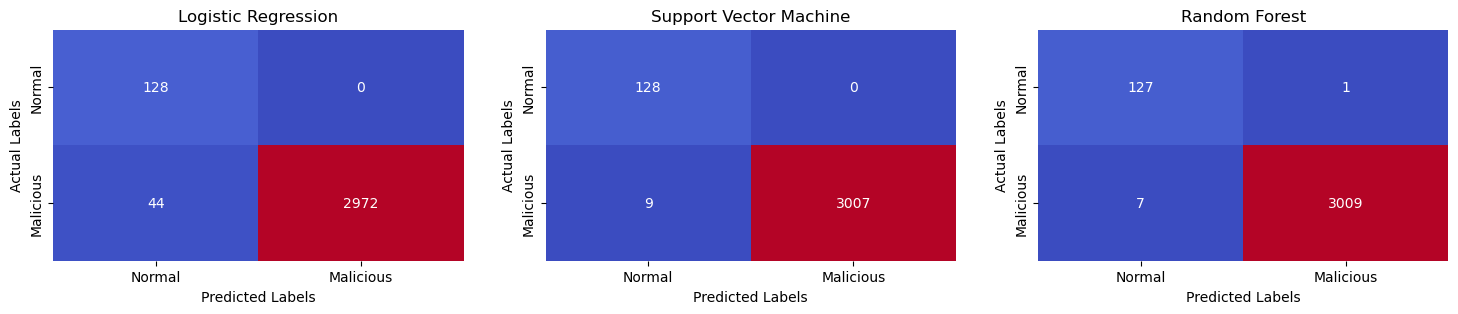

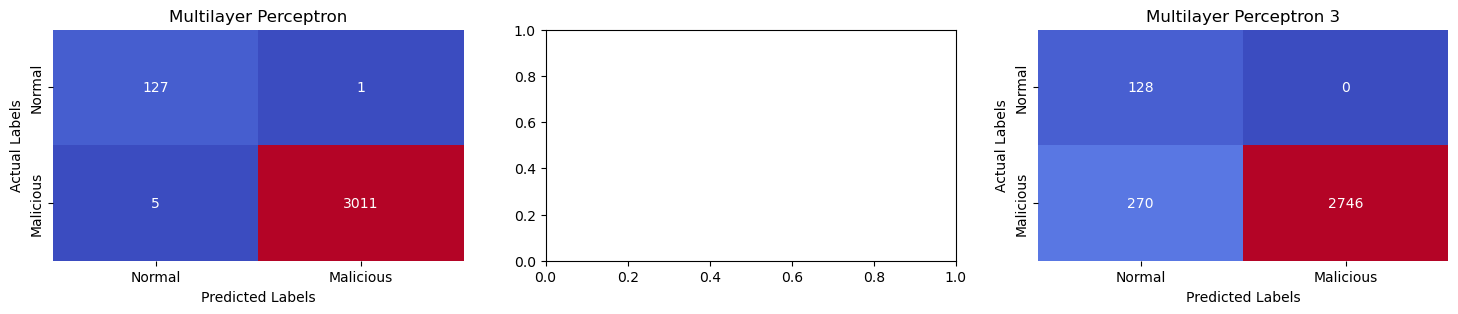

In [82]:
fig, ax1 = plt.subplots(1, 3, figsize=(18, 3))

sns.heatmap(LR_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax1[0])
ax1[0].set_title("Logistic Regression")
ax1[0].set_xlabel('Predicted Labels')
ax1[0].set_ylabel('Actual Labels')
ax1[0].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax1[0].xaxis.set_ticklabels(['Normal', 'Malicious'])

sns.heatmap(SVM_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax1[1])
ax1[1].set_title("Support Vector Machine")
ax1[1].set_xlabel('Predicted Labels')
ax1[1].set_ylabel('Actual Labels')
ax1[1].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax1[1].xaxis.set_ticklabels(['Normal', 'Malicious'])

sns.heatmap(RF_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax1[2])
ax1[2].set_title("Random Forest")
ax1[2].set_xlabel('Predicted Labels')
ax1[2].set_ylabel('Actual Labels')
ax1[2].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax1[2].xaxis.set_ticklabels(['Normal', 'Malicious'])

fig, ax2 = plt.subplots(1, 3, figsize=(18, 3))

sns.heatmap(MLP_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax2[0])
ax2[0].set_title("Multilayer Perceptron")
ax2[0].set_xlabel('Predicted Labels')
ax2[0].set_ylabel('Actual Labels')
ax2[0].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax2[0].xaxis.set_ticklabels(['Normal', 'Malicious'])


sns.heatmap(MLP3_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax2[2])
ax2[2].set_title("Multilayer Perceptron 3")
ax2[2].set_xlabel('Predicted Labels')
ax2[2].set_ylabel('Actual Labels')
ax2[2].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax2[2].xaxis.set_ticklabels(['Normal', 'Malicious'])

plt.show()

In [84]:
from sklearn.metrics import classification_report, accuracy_score

# Predictions dictionary
predictions = {
    "Logistic Regression": predict_LR,
    "SVM": predict_SVM,
    "Random Forest": predict_RF,
    "MLP": predict_MLP,
    "MLP3": predict_MLP3
}

# Metrics dictionary
results = {
    name: classification_report(y_test, pred, output_dict=True)
    for name, pred in predictions.items()
}

# Summary table
summary_data = []

for model, metrics in results.items():
    summary_data.append({
        "Model": model,
        "Accuracy": accuracy_score(y_test, predictions[model]),
        "Precision": metrics["weighted avg"]["precision"],
        "Recall": metrics["weighted avg"]["recall"],
        "F1-score": metrics["weighted avg"]["f1-score"]
    })

summary_df = pd.DataFrame(summary_data).set_index("Model")
print(summary_df.round(4))



                     Accuracy  Precision  Recall  F1-score
Model                                                     
Logistic Regression    0.9860     0.9896  0.9860    0.9870
SVM                    0.9971     0.9973  0.9971    0.9972
Random Forest          0.9975     0.9976  0.9975    0.9975
MLP                    0.9981     0.9981  0.9981    0.9981
MLP3                   0.9141     0.9724  0.9141    0.9342


## Fianl Features interpretability

In [106]:
print("Feature importance length:", len(modelRF.feature_importances_))


Feature importance length: 4


In [107]:
print("X_train type:", type(X_train))
if isinstance(X_train, pd.DataFrame):
    print("X_train columns:", X_train.columns.tolist())
else:
    print("X_train shape:", X_train.shape)

X_train type: <class 'pandas.core.frame.DataFrame'>
X_train columns: ['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']


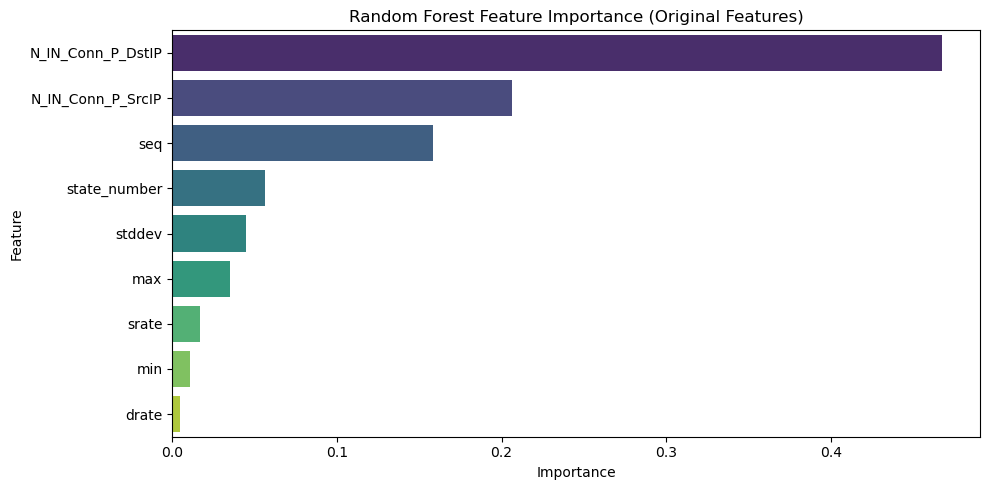

In [109]:
modelRF = RandomForestClassifier(random_state=37)
modelRF.fit(X_train, y_train)

importances = modelRF.feature_importances_
feat_keys = X_train.columns.tolist()

assert len(feat_keys) == len(importances), "Mismatch still exists!"

feat_imp_df = pd.DataFrame({
    'Feature': feat_keys,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette="viridis")
plt.title("Random Forest Feature Importance (Original Features)")
plt.tight_layout()
plt.show()

In [114]:
feature_importance_list = [
    f"Feature: {row.Feature}, Importance: {row.Importance:.4f}"
    for _, row in feat_imp_df.iterrows()
]
print(feature_importance_list)

['Feature: N_IN_Conn_P_DstIP, Importance: 0.4670', 'Feature: N_IN_Conn_P_SrcIP, Importance: 0.2064', 'Feature: seq, Importance: 0.1585', 'Feature: state_number, Importance: 0.0562', 'Feature: stddev, Importance: 0.0445', 'Feature: max, Importance: 0.0349', 'Feature: srate, Importance: 0.0168', 'Feature: min, Importance: 0.0108', 'Feature: drate, Importance: 0.0049']


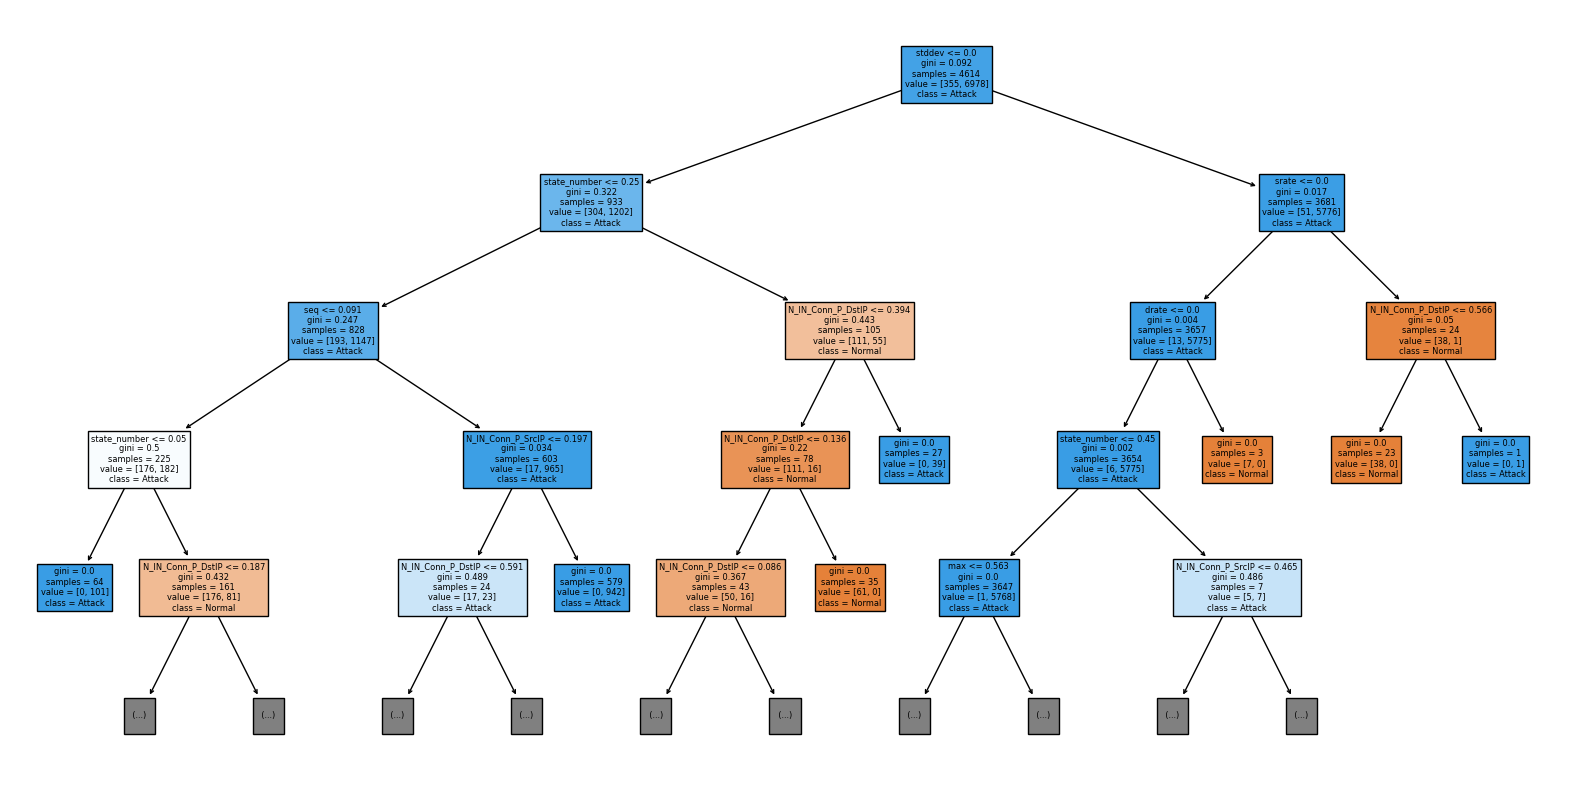

In [112]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(modelRF.estimators_[0], feature_names=feat_keys, class_names=["Normal", "Attack"], filled=True, max_depth=4)
plt.show()

In [113]:
used_features = set()
for tree in modelRF.estimators_:
    used_features.update(tree.tree_.feature[tree.tree_.feature >= 0])

print("Features used across all trees:")
for i in sorted(used_features):
    print(f"- {feat_keys[i]}")


Features used across all trees:
- seq
- stddev
- N_IN_Conn_P_SrcIP
- min
- state_number
- N_IN_Conn_P_DstIP
- drate
- srate
- max


In [117]:
# Gain-based importance from XGBoost
xgb_importance = xg_reg.get_score(importance_type='gain')
xgb_importance_df = pd.DataFrame.from_dict(xgb_importance, orient='index', columns=['Importance'])
xgb_importance_df.index.name = 'Feature'
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
xgb_importance_df.reset_index(inplace=True)

# Print result
for row in xgb_importance_df.itertuples():
    print(f"Feature: {row.Feature}, Importance: {row.Importance:.4f}")


Feature: N_IN_Conn_P_DstIP, Importance: 29.7468
Feature: state_number, Importance: 25.8117
Feature: srate, Importance: 18.3331
Feature: min, Importance: 13.9271
Feature: N_IN_Conn_P_SrcIP, Importance: 13.4279
Feature: max, Importance: 12.5842
Feature: stddev, Importance: 12.5188
Feature: drate, Importance: 11.3419
Feature: mean, Importance: 11.1302
Feature: seq, Importance: 9.8473


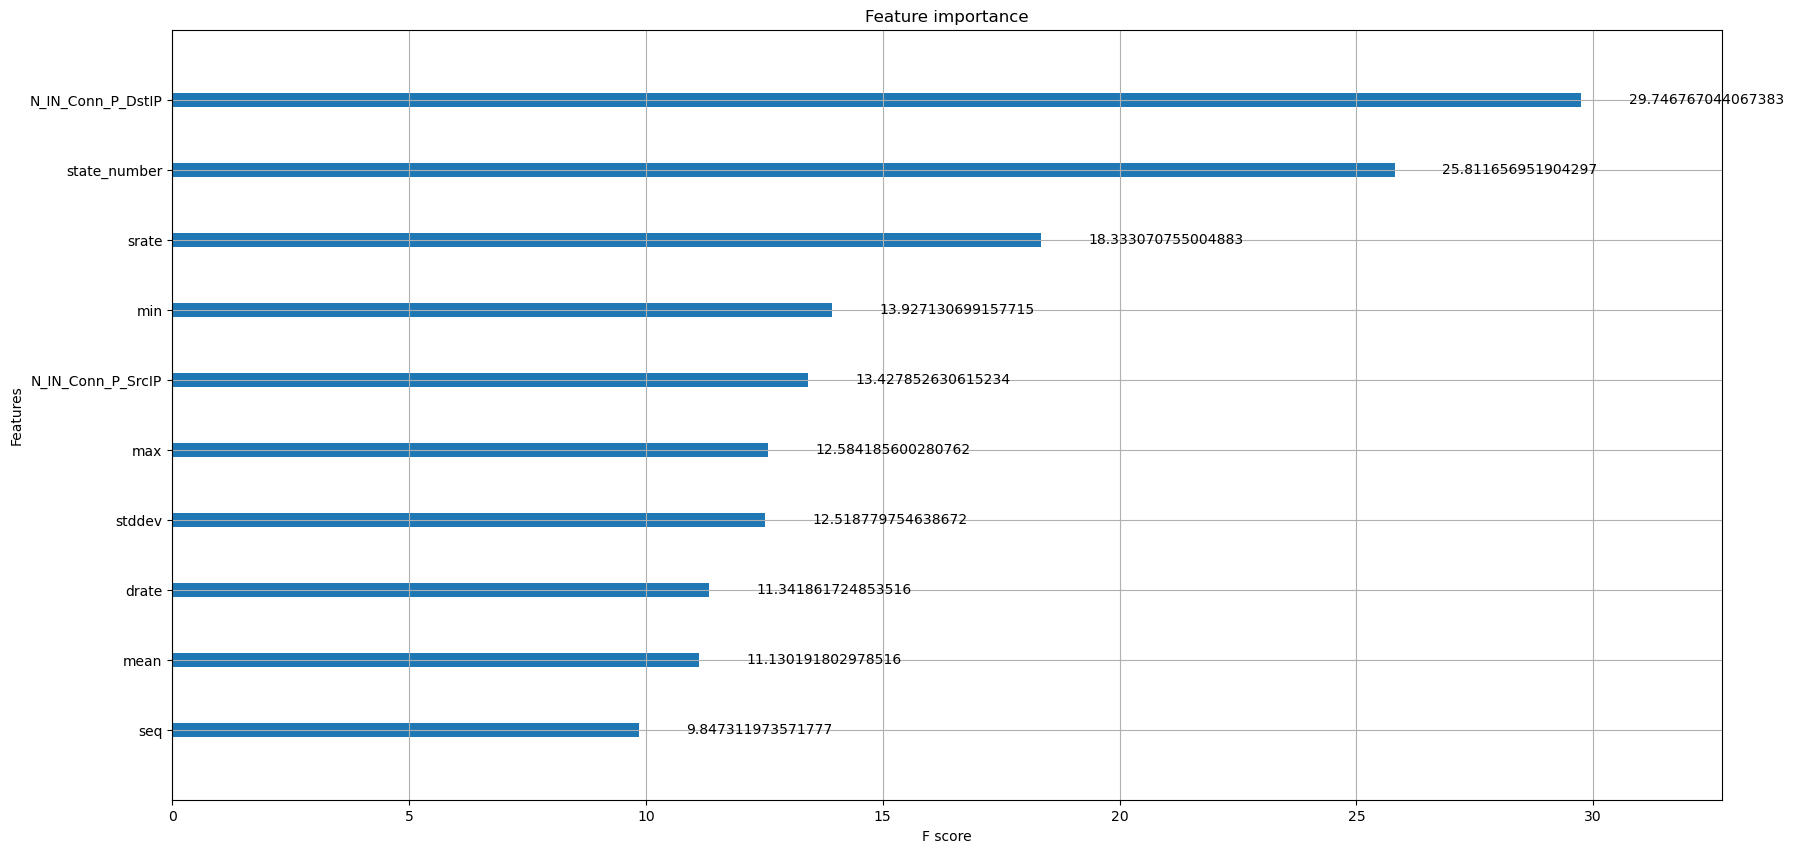

In [119]:
params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.3,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 8,
    'seed': 1337,
    'eval_metric': 'logloss'  # or 'auc', optional but recommended
}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=500)


#Feature importance graph
plt.rcParams['figure.figsize'] = [20, 10]
xgb.plot_importance(xg_reg, importance_type='gain')
plt.show()